In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize
from mmctools.helper_functions import calc_uv
from mpl_toolkits.basemap import Basemap
from collections import Counter
from mmctools.helper_functions import calc_wind, lowess_mean, w_s, T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader
import pickle
from mmctools.plotting import TaylorDiagram
import sys
sys.path.append('../')
from pydicts.obsdict import read_AWOS
import pydicts.baybreezedict as bbd

In [3]:
f_dir = '/Users/hawbecke/Research/Chesapeake/Data/WRF/SENSITIVITY_TESTS/BB_2019062518_Jmz_GHR_1D/'
wrfout_files = sorted(glob.glob('{}wrfout_d03*'.format(f_dir)))

In [6]:
for zi,zz in enumerate(zs): print(zi,zz)

0 2.794157
1 7.9965696
2 13.199625
3 18.403736
4 23.60939
5 28.978373
6 34.59159
7 40.44925
8 46.592186
9 53.061356
10 59.857666
11 67.022064
12 74.55502
13 82.41725
14 90.64992
15 99.334946
16 108.43294
17 117.98565
18 128.03464
19 138.5405
20 149.586
21 161.21344
22 173.3836
23 186.13911
24 199.56386
25 213.6596
26 228.42897
27 243.91605
28 260.2054
29 277.3002
30 295.2041
31 314.00327
32 333.78467
33 354.5115
34 376.2303
35 399.07104
36 422.99844
37 448.10223
38 474.4734
39 502.12042
40 531.81036
41 564.4442
42 600.2994
43 639.70166
44 682.9838
45 730.48694
46 782.6897
47 839.9973
48 902.9159
49 972.01135
50 1047.7843
51 1130.8905
52 1222.0608
53 1322.0199
54 1431.5369
55 1551.5728
56 1683.1128
57 1827.135
58 1984.8561
59 2157.5137
60 2346.4312
61 2553.1333
62 2779.189
63 3026.2908
64 3296.2866
65 3591.1812
66 3913.1143
67 4264.3545
68 4647.217
69 5064.007
70 5516.9844
71 6008.318
72 6540.1953
73 7114.8125
74 7734.759
75 8402.209
76 9118.557
77 9872.923
78 10628.648
79 11360.898
80 

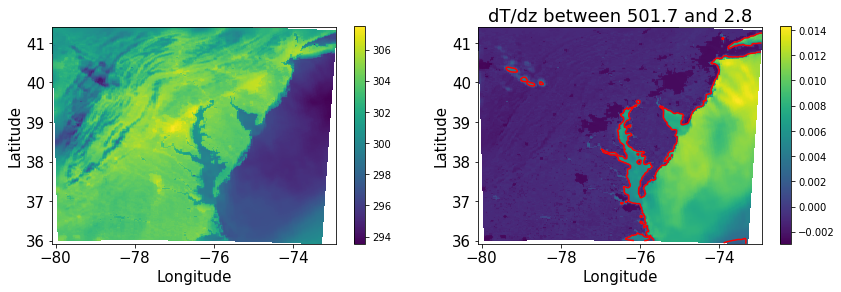

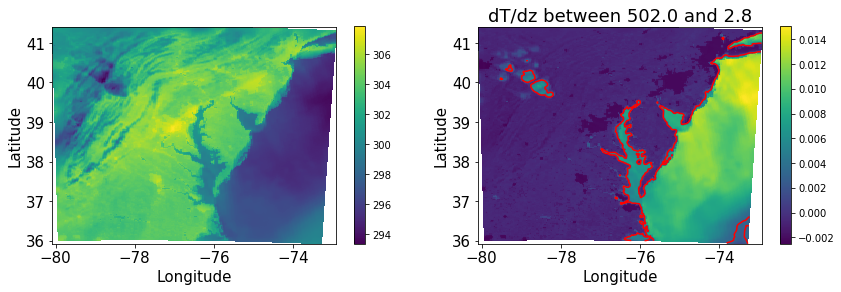

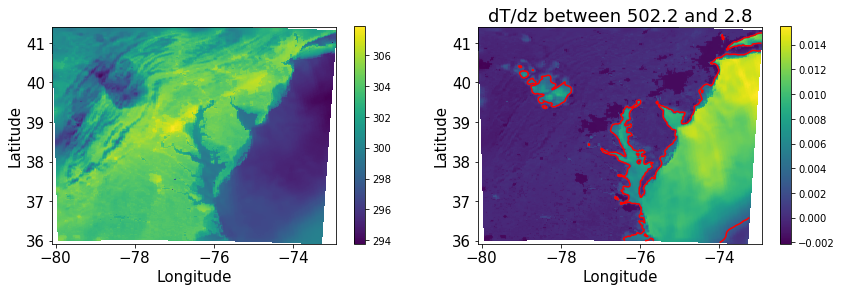

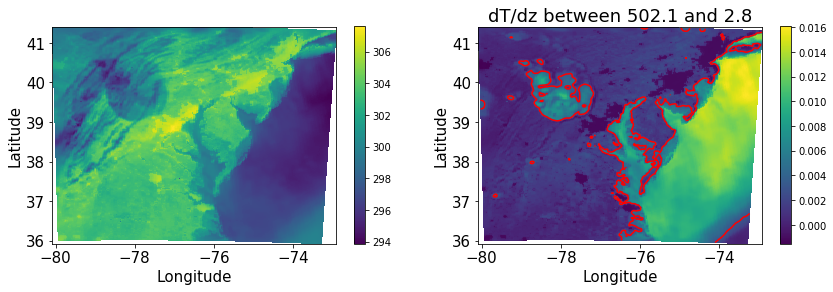

In [5]:
for wrfout_f in wrfout_files:
    wrfout = xr.open_dataset(wrfout_f)
    lon = np.squeeze(wrfout.XLONG)
    lat = np.squeeze(wrfout.XLAT)
    t2 = np.squeeze(wrfout.T2)
    temp = np.squeeze(wrfout.T)
    z_f = (np.squeeze(wrfout.PH) + np.squeeze(wrfout.PHB))/9.8 - np.squeeze(wrfout.HGT)
    zs_f = 0.5*(z_f[1:,:,:]+z_f[:-1,:,:])
    z = np.mean(np.mean(z_f.data,axis=1),axis=1)
    zs = 0.5*(z[1:] + z[:-1])
    #for zi,zz in enumerate(zs): print(zi,zz)
    top_ind = 39
    bot_ind = 0
    dTdz = (temp[top_ind,:,:] - temp[bot_ind,:,:]) / (zs_f[top_ind,:,:] - zs_f[bot_ind,:,:])
    
    fig = plt.figure(figsize=(14,4)) 
    t2_plt = plt.subplot2grid((1,2),(0,0),aspect='equal')
    t2_plt_cm = t2_plt.pcolormesh(lon,lat,t2)
    plt.colorbar(t2_plt_cm,ax=t2_plt)
    t2_plt.tick_params(labelsize=15)
    t2_plt.set_xlabel('Longitude',size=15)
    t2_plt.set_ylabel('Latitude',size=15)
    
    dT_plt = plt.subplot2grid((1,2),(0,1),aspect='equal')
    dT_plt_cm = dT_plt.pcolormesh(lon,lat,dTdz)
    plt.colorbar(dT_plt_cm,ax=dT_plt)
    dT_plt.contour(lon,lat,dTdz,levels=[0.003],colors='r')
    dT_plt.set_title('dT/dz between {0:3.1f} and {1:3.1f}'.format(zs[top_ind],zs[bot_ind]),size=18)
    dT_plt.tick_params(labelsize=15)
    dT_plt.set_xlabel('Longitude',size=15)
    dT_plt.set_ylabel('Latitude',size=15)
    
    plt.show()
    

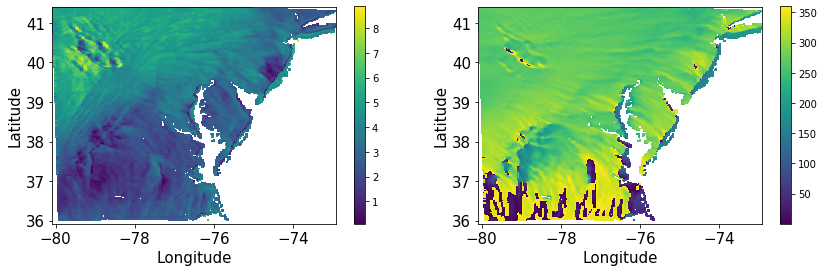

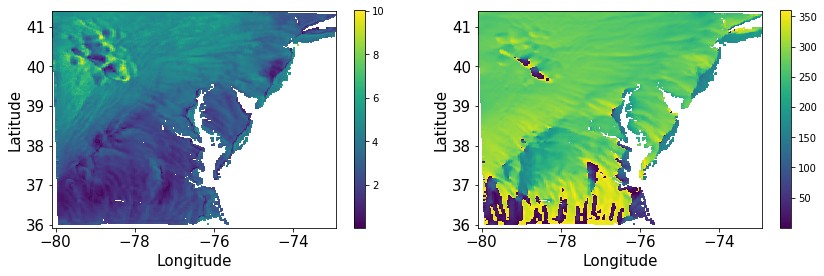

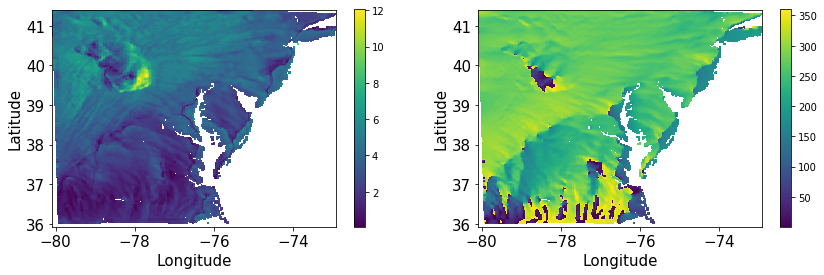

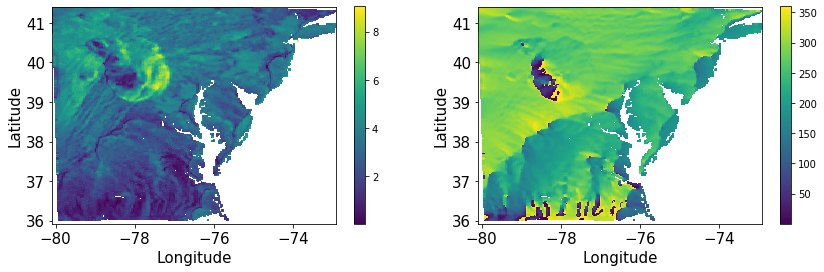

In [61]:
col_or_sfc = 'sfc'
for wrfout_f in wrfout_files:
    wrfout = xr.open_dataset(wrfout_f)
    lon = np.squeeze(wrfout.XLONG)
    lat = np.squeeze(wrfout.XLAT)
    water_depth = np.squeeze(wrfout.WATER_DEPTH)
    hgt = np.squeeze(wrfout.HGT)
    land_mask = water_depth.where((water_depth==10.0) & (hgt > 0.0))
    land_mask /= land_mask
    t2 = np.squeeze(wrfout.T2)
    if col_or_sfc == 'col':
        wspd,wdir = calc_wind(wrfout,u='U',v='V')      
    elif col_or_sfc == 'sfc':
        wspd,wdir = calc_wind(wrfout,u='U10',v='V10')
    wspd = np.squeeze(wspd).where(land_mask==1.0)
    wdir = np.squeeze(wdir).where(land_mask==1.0)
    z_f = (np.squeeze(wrfout.PH) + np.squeeze(wrfout.PHB))/9.8 - np.squeeze(wrfout.HGT)
    zs_f = 0.5*(z_f[1:,:,:]+z_f[:-1,:,:])
    z = np.mean(np.mean(z_f.data,axis=1),axis=1)
    zs = 0.5*(z[1:] + z[:-1])
    #for zi,zz in enumerate(zs): print(zi,zz)
    top_ind = 39
    bot_ind = 0
    dTdz = (temp[top_ind,:,:] - temp[bot_ind,:,:]) / (zs_f[top_ind,:,:] - zs_f[bot_ind,:,:])
    
    fig = plt.figure(figsize=(14,4)) 
    t2_plt = plt.subplot2grid((1,2),(0,0),aspect='equal')
    t2_plt_cm = t2_plt.pcolormesh(lon,lat,wspd)
    plt.colorbar(t2_plt_cm,ax=t2_plt)
    t2_plt.tick_params(labelsize=15)
    t2_plt.set_xlabel('Longitude',size=15)
    t2_plt.set_ylabel('Latitude',size=15)
    
    dT_plt = plt.subplot2grid((1,2),(0,1),aspect='equal')
    dT_plt_cm = dT_plt.pcolormesh(lon,lat,wdir)
    plt.colorbar(dT_plt_cm,ax=dT_plt)
    #dT_plt.contour(lon,lat,dTdz,levels=[0.003],colors='r')
    #dT_plt.set_title('dT/dz between {0:3.1f} and {1:3.1f}'.format(zs[top_ind],zs[bot_ind]),size=18)
    dT_plt.tick_params(labelsize=15)
    dT_plt.set_xlabel('Longitude',size=15)
    dT_plt.set_ylabel('Latitude',size=15)
    
    plt.show()
    

In [47]:
nx = len(wrfout.west_east)
ny = len(wrfout.south_north)

In [91]:
h_window = 15

smooth_dir = wdir.copy()

for ii in range(0,nx):
    for jj in range(0,ny):
        if ((ii >= h_window) & (jj >= h_window)) & ((ii <= nx-h_window) & (jj <= ny-h_window)):
            dir_window = wdir.data[jj-h_window:jj+h_window+1,ii-h_window:ii+h_window+1].copy()
            dir_window_range = np.nanmax(dir_window) - np.nanmin(dir_window)
            if dir_window_range > 300.0:
                #print(dir_window)
                if np.nanmedian(dir_window) < 180.0:
                    dir_window[dir_window >= 270.0] -= 360.0
                else:
                    dir_window[dir_window <= 90.0] += 360.0

            smooth_dir[jj,ii] = np.nanmean(dir_window)
        else:
            smooth_dir[jj,ii] = np.nan
            
        


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [92]:
smooth_dir = smooth_dir.where(land_mask==1.0)

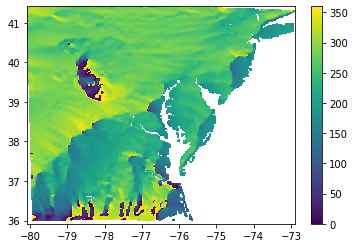

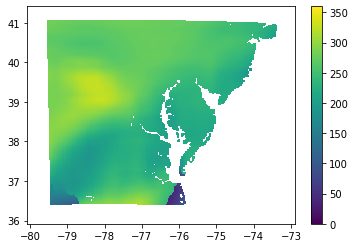

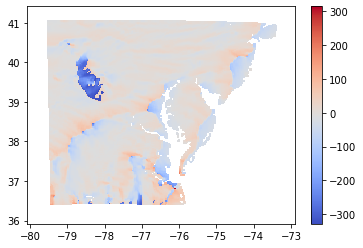

In [96]:
plt.pcolormesh(lon,lat,wdir,norm=Normalize(0,360))
plt.colorbar()
plt.show()
plt.pcolormesh(lon,lat,smooth_dir,norm=Normalize(0,360))
plt.colorbar()
plt.show()
wdir_diff = wdir-smooth_dir
plt.pcolormesh(lon,lat,wdir_diff,cmap=plt.cm.coolwarm)#,norm=Normalize(0,360))
plt.colorbar()
plt.show()

In [28]:
wrfout

<xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 87, bottom_top_stag: 88, seed_dim_stag: 2, south_north: 201, south_north_stag: 202, west_east: 201, west_east_stag: 202)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, seed_dim_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    U                      (Time, bottom_top, south_north, west_east_stag) float32 ...
    V                      (Time, bottom_top, south_north_stag, west_east) float32 ...
    W                      (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH                     (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    T                      (Time, bottom_top, south_north, west_east) float32 ...
    THM                    (Time, bottom_top, south_north, west_east) float32 ...
    HFX_FORCE              (Time) float32 ...
    LH_FORCE               (Time) float32 ...
    TSK_FORCE              (Time) float32 ...
    HFX_FORCE_TEND         (Time) float32 ...
    LH_FORCE_TEND          (Time) float32 ...
    TSK_FORCE_TEND         (Time) float32 ...
    MU                     (Time, south_north, west_east) float32 ...
    MUB                    (Time, south_north, west_east) float32 ...
    MUU                    (Time, south_north, west_east_stag) float32 ...
    MUV                    (Time, south_north_stag, west_east) float32 ...
    MUT                    (Time, south_north, west_east) float32 ...
    P                      (Time, bottom_top, south_north, west_east) float32 ...
    PB                     (Time, bottom_top, south_north, west_east) float32 ...
    FNM                    (Time, bottom_top) float32 ...
    FNP                    (Time, bottom_top) float32 ...
    RDNW                   (Time, bottom_top) float32 ...
    RDN                    (Time, bottom_top) float32 ...
    DNW                    (Time, bottom_top) float32 ...
    DN                     (Time, bottom_top) float32 ...
    CFN                    (Time) float32 ...
    CFN1                   (Time) float32 ...
    THIS_IS_AN_IDEAL_RUN   (Time) int32 ...
    Q2                     (Time, south_north, west_east) float32 ...
    T2                     (Time, south_north, west_east) float32 ...
    TH2                    (Time, south_north, west_east) float32 ...
    PSFC                   (Time, south_north, west_east) float32 ...
    U10                    (Time, south_north, west_east) float32 -0.24809267 ... 1.3181468
    V10                    (Time, south_north, west_east) float32 -1.5091795 ... 0.71602464
    RESM                   (Time) float32 ...
    ZETATOP                (Time) float32 ...
    CF1                    (Time) float32 ...
    CF2                    (Time) float32 ...
    CF3                    (Time) float32 ...
    ITIMESTEP              (Time) int32 ...
    GRDFLX                 (Time, south_north, west_east) float32 ...
    ACGRDFLX               (Time, south_north, west_east) float32 ...
    WATER_DEPTH            (Time, south_north, west_east) float32 10.0 ... 10.0
    F                      (Time, south_north, west_east) float32 ...
    COSALPHA               (Time, south_north, west_east) float32 ...
    HGT

# User settings:

In [7]:
obs_dir   = '/Users/hawbecke/Research/Chesapeake/Data/Obs/'
wrf_dir   = '/Users/hawbecke/Research/Chesapeake/Data/WRF/SENSITIVITY_TESTS/'

cases     = ['BB_2019062518_Chk_OST_1D','BB_2019062518_Jmz_OST_1D',
             'BB_2019062518_Jmz_GHR_1D','BB_2019062518_Jmz_MOD_1D']
ncases = len(cases)
start_time = '2019-06-25 18:00'
end_time   = '2019-06-27 06:00'


# Read in WRF data:

In [8]:
wrf_twrs = {}
for cc,case in enumerate(cases):
    wrf_twrs[case] = tsout_seriesReader('{}{}/towers/'.format(wrf_dir,case),[''],start_time,'d03',
                                  structure='unordered',time_step=10.0)


TypeError: 'NoneType' object is not iterable

# Read in AWOS data:

In [5]:
if path.exists('{}AWOS/2007_to_2020/AWOS_2007to2020.nc'.format(obs_dir)):
    print('loading in full dataset!')
    ds_stn = xr.open_dataset('{}AWOS/2007_to_2020/AWOS_2007to2020.nc'.format(obs_dir))
    print('Dataset spans from {} to {}'.format(pd.to_datetime(ds_stn.datetime[0].values).year,
                                           pd.to_datetime(ds_stn.datetime[-1].values).year))
else:
    print('Need to run BayBreezeDetection notebook...')

loading in full dataset!
Dataset spans from 2007 to 2019


In [583]:
if path.exists('{}ASOS/5min/ASOS_2019to2020.nc'.format(obs_dir)):
    print('loading in full dataset!')
    ds_stn = xr.open_dataset('{}ASOS/5min/ASOS_2019to2020.nc'.format(obs_dir))
    print('Dataset spans from {} to {}'.format(pd.to_datetime(ds_stn.datetime[0].values).year,
                                           pd.to_datetime(ds_stn.datetime[-1].values).year))
else:
    print('Need to run BayBreezeDetection notebook...')

loading in full dataset!
Dataset spans from 2019 to 2020


In [584]:
case_day_ds = ds_stn.sel(datetime=slice(start_time,end_time))

In [585]:
for kk in (wrf_twrs['BB_2019062518_Chk_OST_1D'].sel(station='APG').height.data[0,:5] - 
           wrf_twrs['BB_2019062518_Chk_OST_1D'].sel(station='APG').zsurface.values): 
    print(kk)

0.009650000000000603
5.327290000000001
10.56213
15.879490000000004
21.117650000000005


In [586]:
model_colors = ['darkgreen','darkred','darkblue','goldenrod']

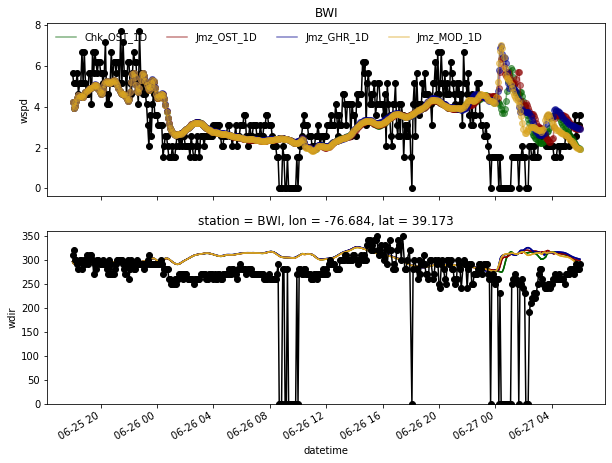

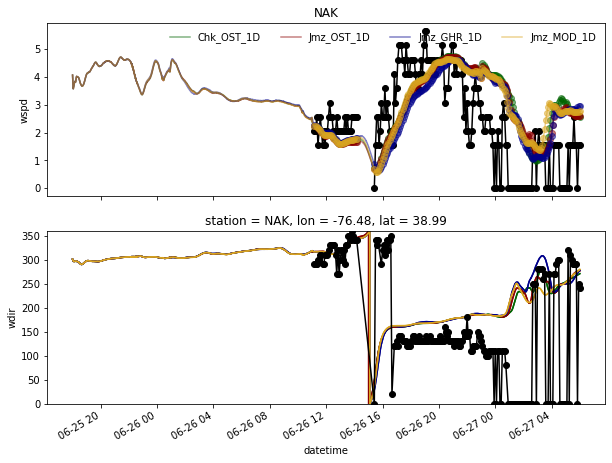

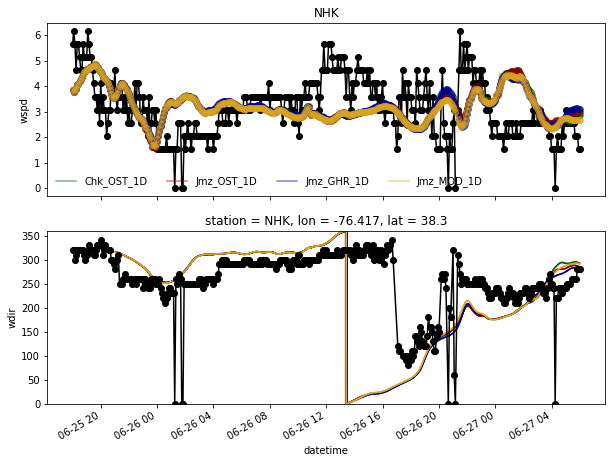

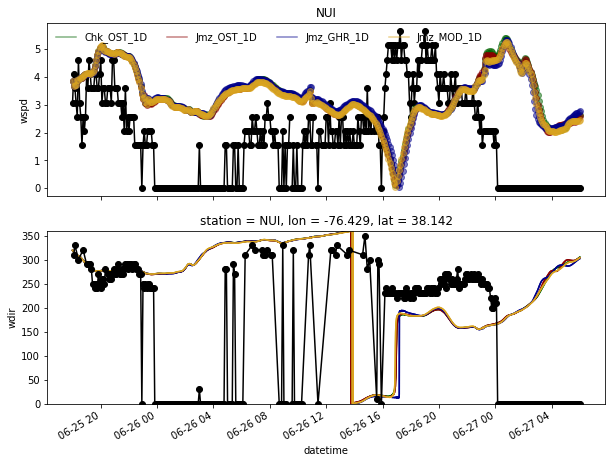

In [590]:
for stn in near_shore_stations:
    fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True)
    case_day_ds.sel(station=stn).wspd.plot(ax=ax[0],marker='o',c='k')
    for tt,twr in enumerate(wrf_twrs):
        twr_dat = wrf_twrs[twr]
        twr_dat.sel(station=stn).isel(nz=2).wspd.plot(ax=ax[0],c=model_colors[tt],alpha=0.5,
                                                     label='_'.join(twr.split('_')[2:]))
        twr_dat.sel(station=stn).sel(datetime=case_day_ds.sel(station=stn).wspd.dropna(
                        how='all',dim='datetime').datetime.values,method='nearest').wspd.isel(
                        nz=2).plot(ax=ax[0],c=model_colors[tt],marker='o',lw=0.0,alpha=0.5)
        twr_dat.sel(station=stn).isel(nz=2).wdir.plot(ax=ax[1],c=model_colors[tt])
        twr_dat.sel(station=stn).isel(nz=2).wdir.plot(ax=ax[1],c=model_colors[tt])
    #wrf_jmnz_ost.sel(station=stn).isel(nz=2).wspd.plot(ax=ax[0],c='darkred',alpha=0.5)
    #wrf_jmnz_ost.sel(station=stn).sel(datetime=case_day_ds.sel(station=stn).wspd.dropna(
    #                how='all',dim='datetime').datetime.values,method='nearest').wspd.isel(
    #                nz=2).plot(ax=ax[0],c='darkred',marker='o',lw=0.0)
    
    case_day_ds.sel(station=stn).wdir.dropna(how='all',dim='datetime').plot(ax=ax[1],marker='o',c='k')
    ax[0].legend(ncol=4,frameon=False)
    ax[0].set_xlabel('')
    ax[1].set_ylim(0,360)
    ax[0].set_title(stn)
    plt.show()

# Plot the stations:

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


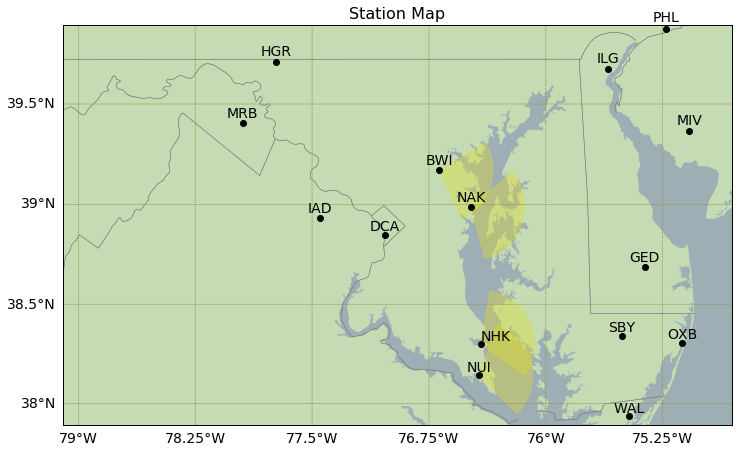

In [588]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-2.7,urcrnrlon=center_lon+1.6, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(38.0,40.1,0.5)
meridians = np.arange(-80.5,-74.9,0.75)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
for stn in ds_stn.station.values:
    x, y = m(ds_stn.sel(station=stn).lon, ds_stn.sel(station=stn).lat)
    ax.scatter(x,y,zorder=3,c='k')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom')
    if ~np.isnan(ds_stn.sel(station=stn).onshore_min.values.astype(float)):
        pts  = np.arange(ds_stn.sel(station=stn).onshore_min.data,ds_stn.sel(station=stn).onshore_max.data,5.0)
        npts = pts.size
        fill_x = [x]
        fill_y = [y]
        for dd,wdir in enumerate(pts):
            d = 270.0 - wdir    # Convert met degrees to polar
            plt_dist = -30000.0 # Met degrees are FROM dir... need negative distance!
            fill_x.append(x+plt_dist*np.cos(np.radians(d)))
            fill_y.append(y+plt_dist*np.sin(np.radians(d)))

        plt.fill(fill_x, fill_y,alpha=0.35,lw=None,color='#e3e022')

    ax.tick_params(size=14)
    ax.set_title('Station Map',size=16)
plt.show()

In [611]:
near_shore_stations = ds_stn.station.data[ds_stn.region.data=='coastal']
inland_stations     = ds_stn.station.data[ds_stn.region.data=='inland']

inland_stations = list(inland_stations)
inland_stations.remove('DCA')
inland_stations.remove('ILG')
inland_stations.remove('MIV')
inland_stations.remove('MRB')
inland_stations.remove('PHL')
inland_stations.remove('WAL')
inland_stations.remove('GED')

# Plot WRF data on bay breeze day:

In [612]:
in_lvls = len(inland_stations)

coastal_colors = plt.cm.nipy_spectral(np.linspace(0,0.9,len(near_shore_stations)))
inland_colors  = plt.cm.rainbow(np.linspace(0,1,len(inland_stations)))

In [23]:
wrf_twrs

{}

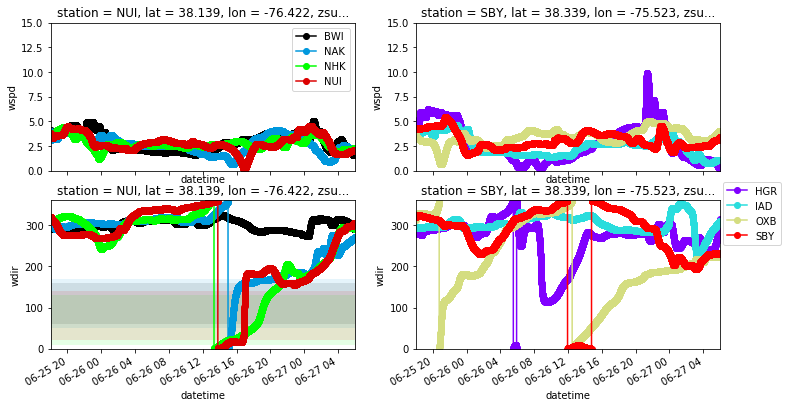

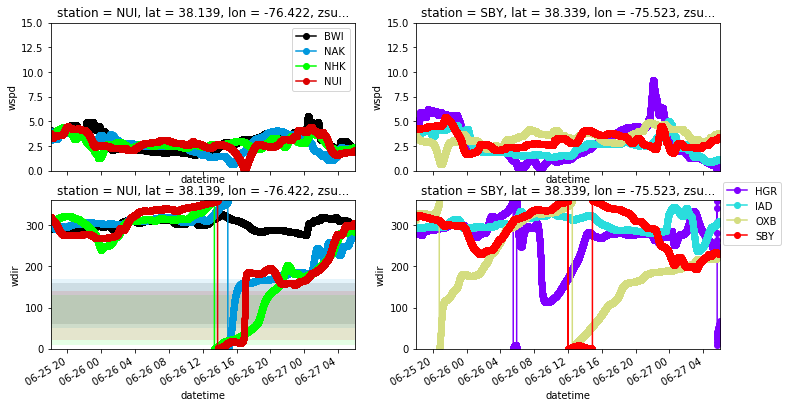

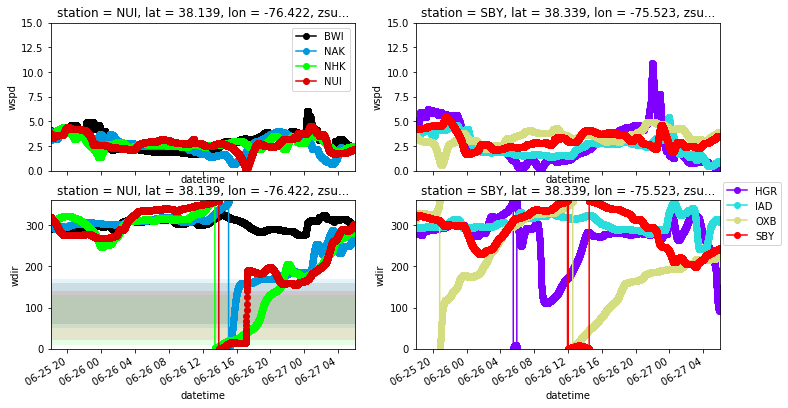

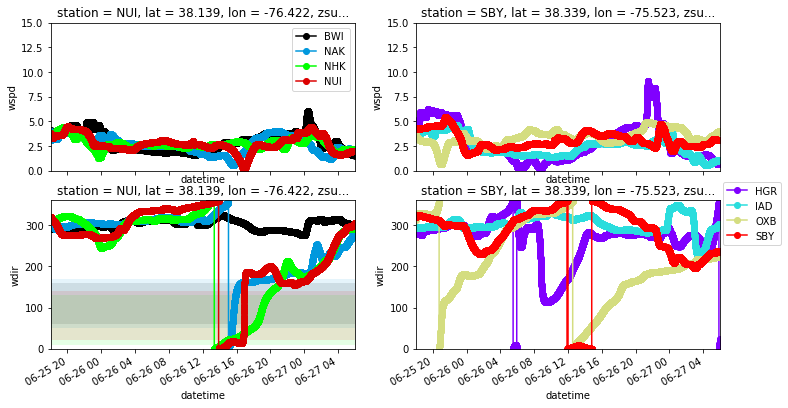

In [613]:
for case in cases:
    fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True, figsize=(12,6))
    wrf_stn = wrf_twrs[case]
    #for day in pd.date_range(start=start_time, end=end_time):
    for ss,stn in enumerate(near_shore_stations): 
        station = wrf_stn.sel(station=stn).sel(datetime=slice(start_time,end_time)).isel(nz=1)

        #bay_breeze_det, bb_start, bb_passage, bb_end = detect_bay_breeze(station,resample=False)
        station.wspd.plot.line(marker='o',ax=ax[0,0],label=stn,c=coastal_colors[ss])
        station.wdir.plot.line(marker='o',ax=ax[1,0],c=coastal_colors[ss])
        ax[1,0].fill_between([pd.to_datetime('2000'),pd.to_datetime('2030')],
                             ds_stn.onshore_min.sel(station=stn),
                             ds_stn.onshore_max.sel(station=stn),
                             alpha=0.1,lw=0.0,color=coastal_colors[ss])
        ax[1,0].set_xlim(station.datetime.data[0],station.datetime.data[-1])

    for ss,instn in enumerate(inland_stations):
        station = wrf_stn.sel(station=instn).sel(datetime=slice(start_time,end_time)).isel(nz=1)
        station.wspd.plot.line(marker='o',ax=ax[0,1],label=instn,c=inland_colors[ss])
        station.wdir.plot.line(marker='o',ax=ax[1,1],c=inland_colors[ss])
        ax[1,1].set_xlim(station.datetime.data[0],station.datetime.data[-1])
    ax[0,0].legend()
    ax[0,1].legend(loc=(1.01,-0.5))
    ax[1,0].set_ylim(0,360)
    ax[1,1].set_ylim(0,360)  
    ax[0,0].set_ylim(0,15)
    ax[0,1].set_ylim(0,15)
    plt.show()

In [614]:
markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X']

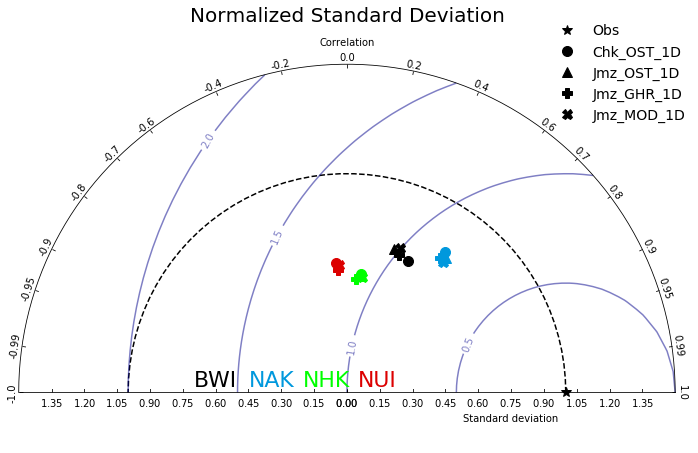

In [615]:
fig_tay = plt.figure(figsize=(12,8))    
dia = TaylorDiagram(1.0, fig=fig_tay, extend=True,
                        label='Obs')
for ss,stn in enumerate(near_shore_stations):
    obs = case_day_ds.sel(station=stn).wspd.dropna(how='all',dim='datetime').resample(
        datetime='30min').interpolate('linear').dropna(how='all',dim='datetime')
    ref_std = np.std(obs.data)

        
    for cc,case in enumerate(cases):
        twr_dat = wrf_twrs[case]
        sim = twr_dat.sel(station=stn).sel(datetime=obs.datetime.values,method='nearest').wspd.isel(nz=2)

        #win_len = len(obs.data)/6.0
        #obs_mean = calc_lowess_mean(obs,win_len,0)
        #sim_mean = calc_lowess_mean(sim,win_len,0)
        if ss == 0: 
            label_str = '_'.join(case.split('_')[2:])
        else:
            label_str = None
        dia.add_sample(np.std(sim.data)/ref_std, np.corrcoef(sim,obs)[0,1],
                       marker=markers[cc], ms=10, ls='',
                       mfc=coastal_colors[ss], mec=coastal_colors[ss], # Colors
                       label=label_str,
                       zorder=4)
    plt.text(-0.7 + 0.25*ss,0.03,stn,c=coastal_colors[ss],size=22)
contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(frameon=False,fontsize=14,loc=(0.8,0.8))
plt.title('Normalized Standard Deviation',size=20,y=1.1)
plt.show()        


In [616]:
detection_method = 'StaufferThompson2015'

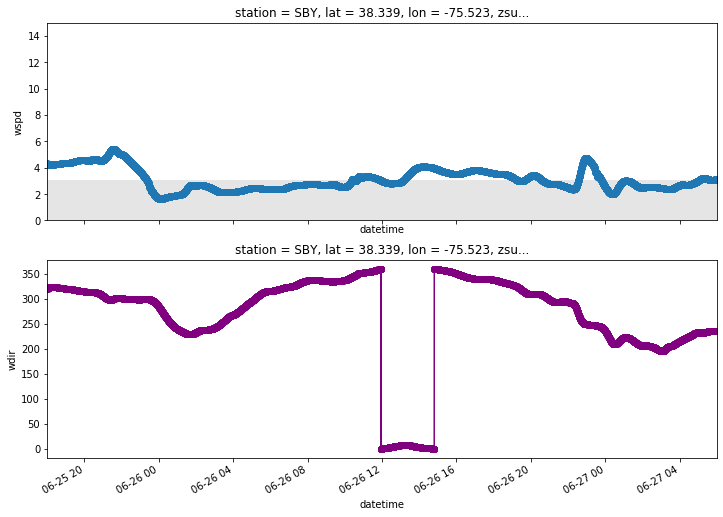

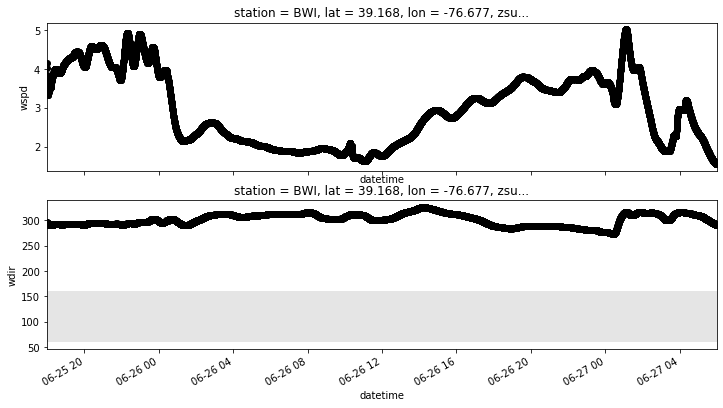

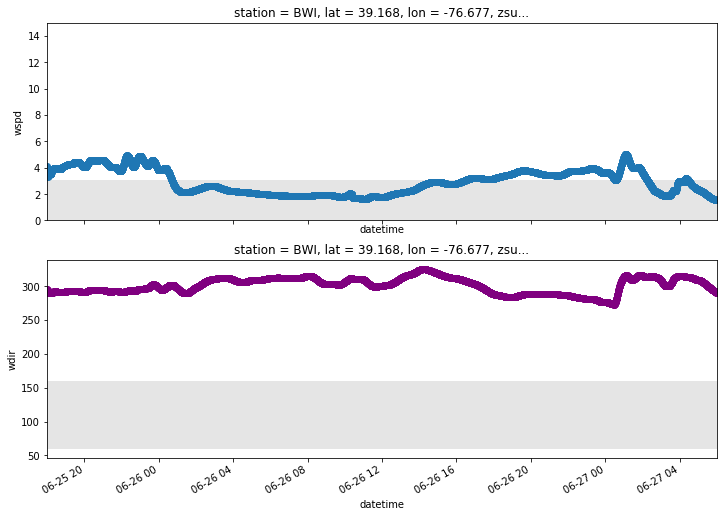

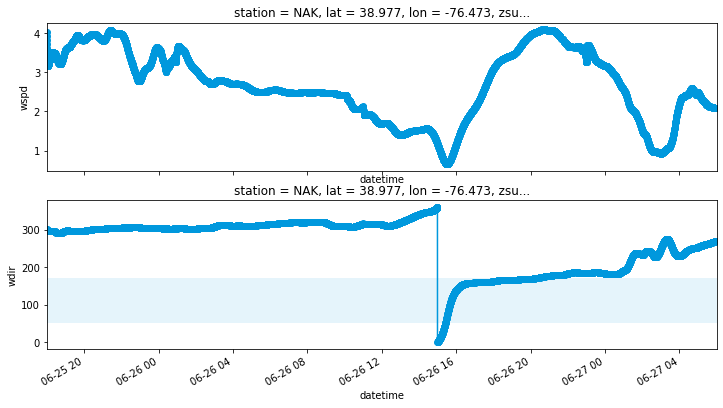

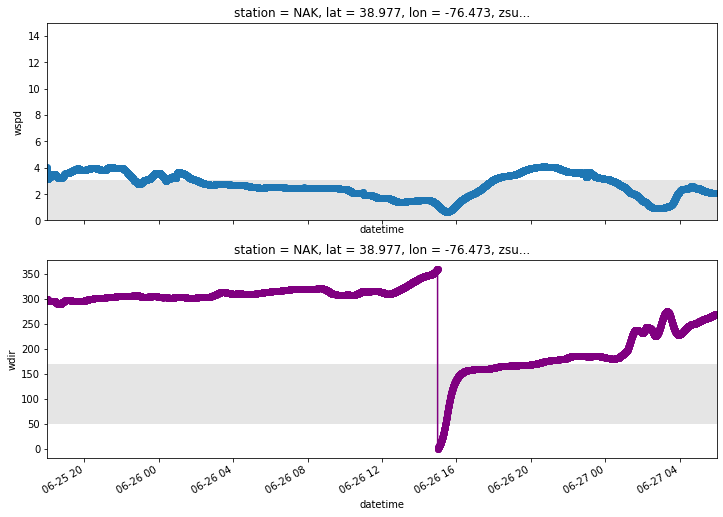

CLR: 12881; OVC: 79
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


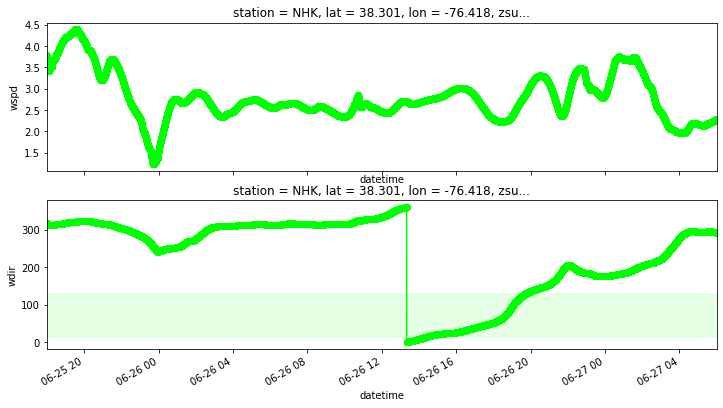

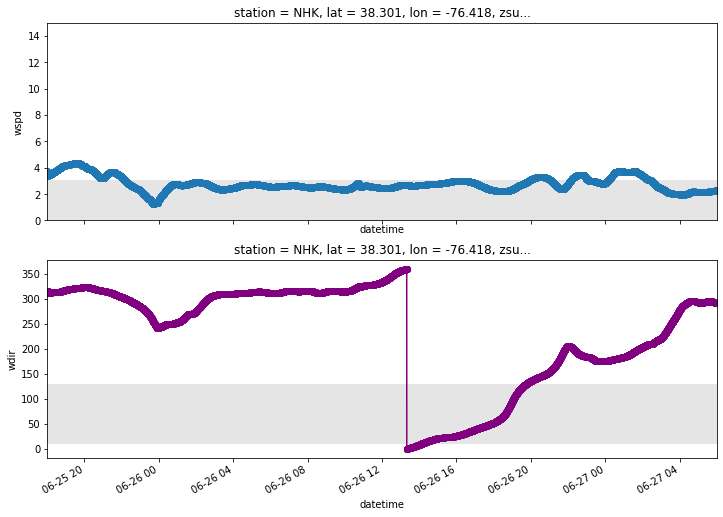

CLR: 11142; OVC: 1818
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


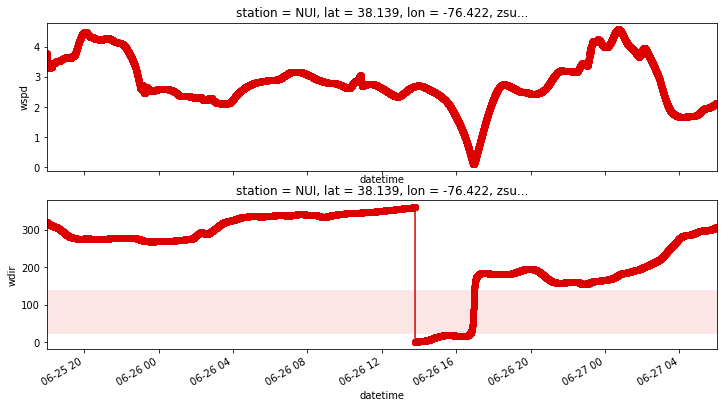

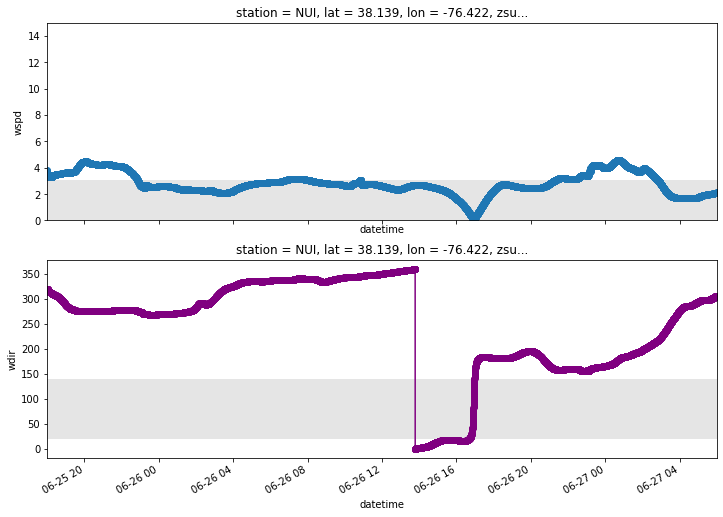

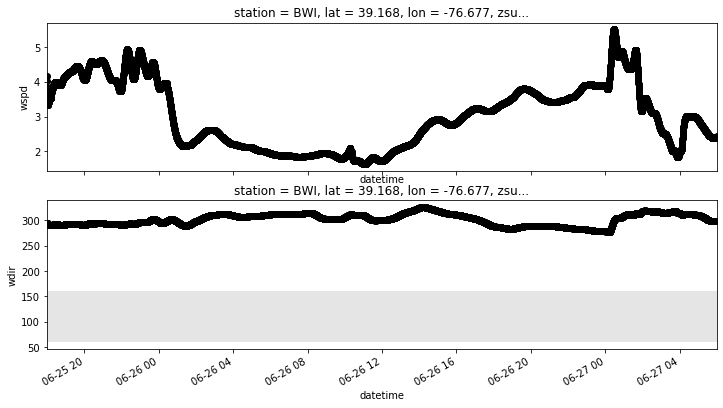

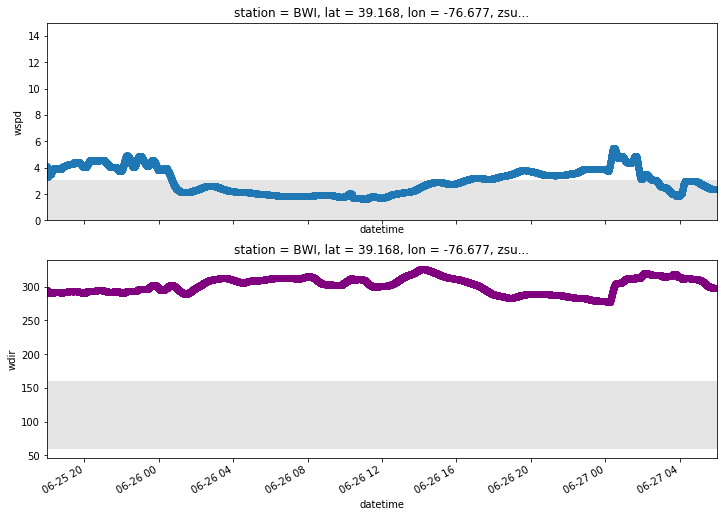

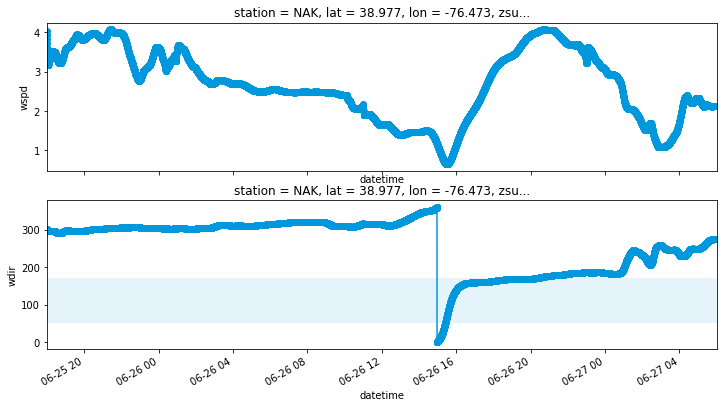

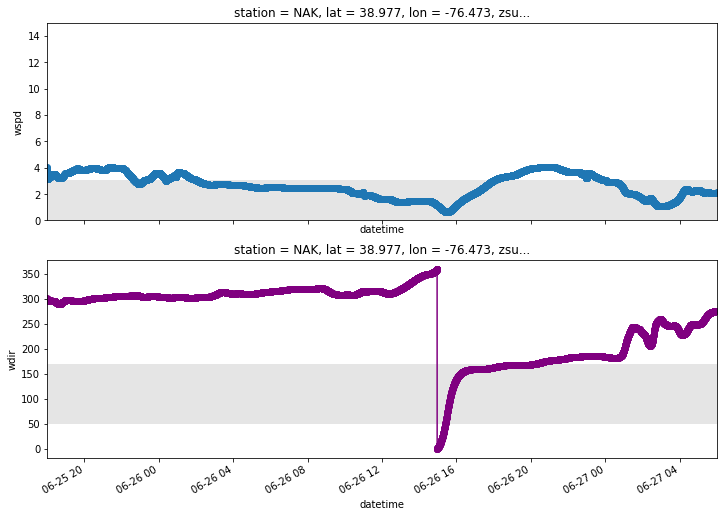

CLR: 12960; OVC: 0
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


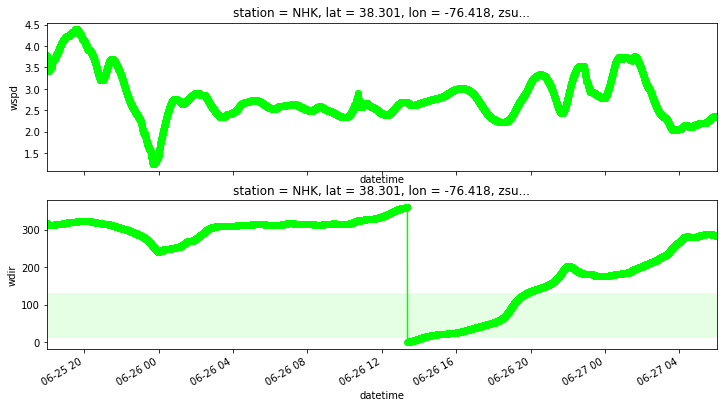

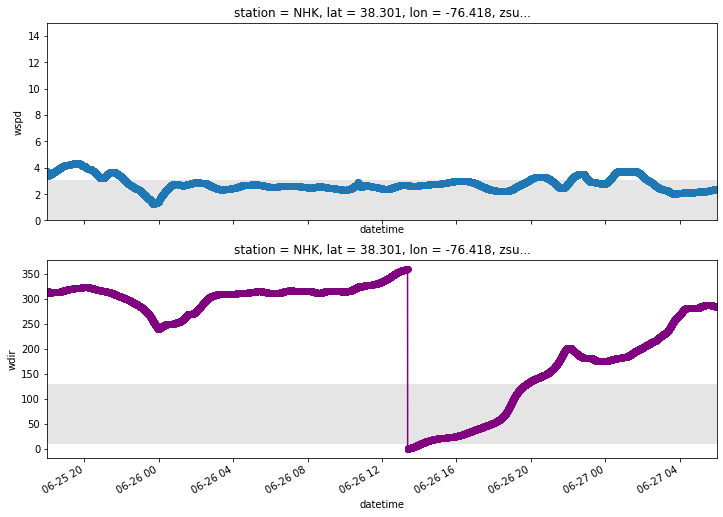

CLR: 11161; OVC: 1799
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


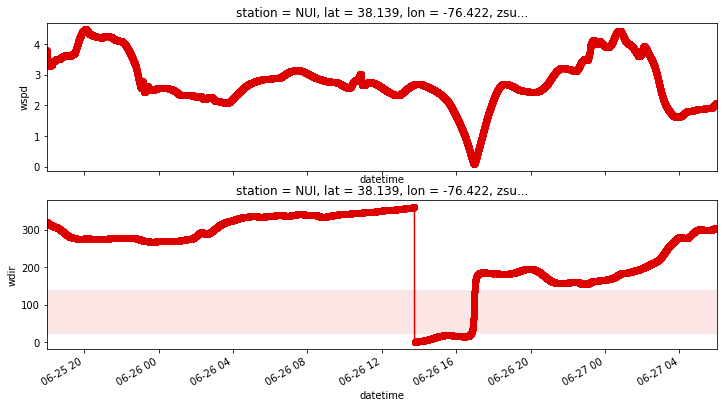

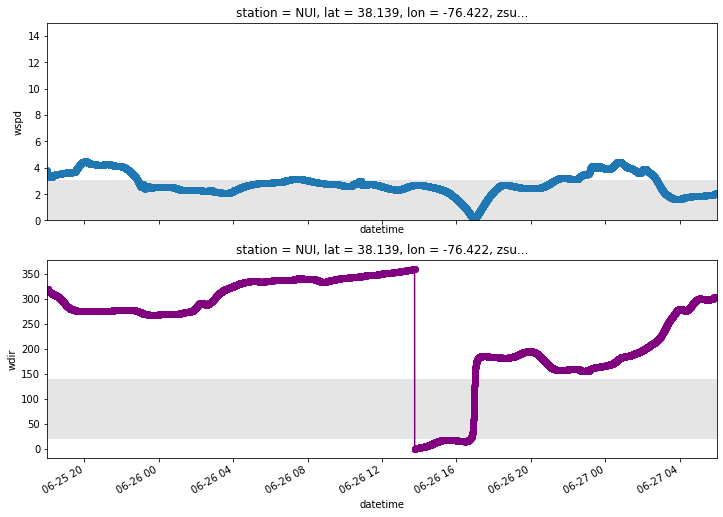

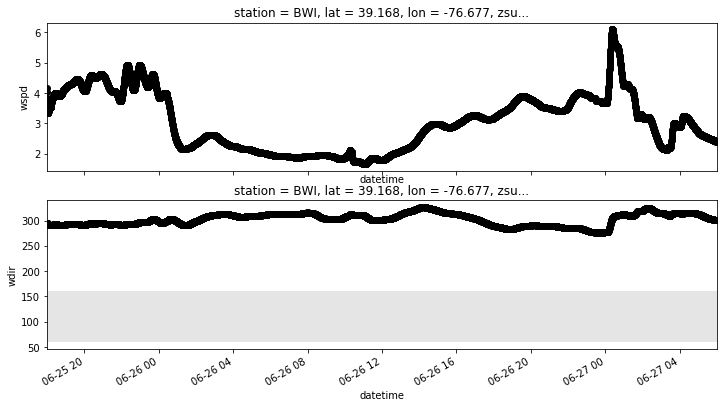

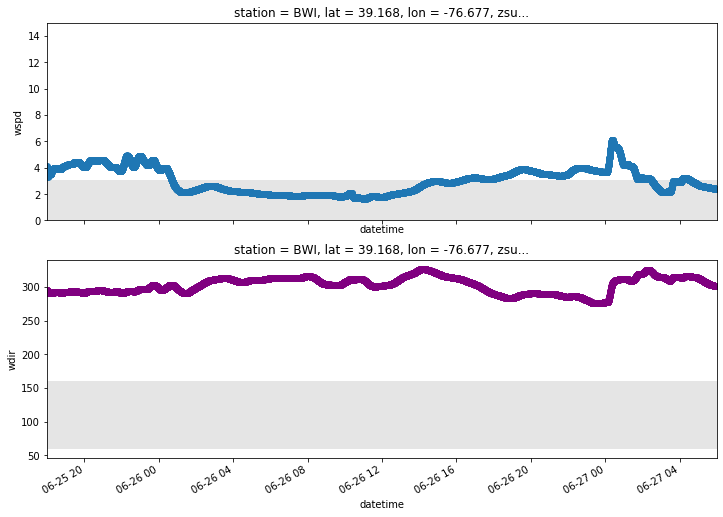

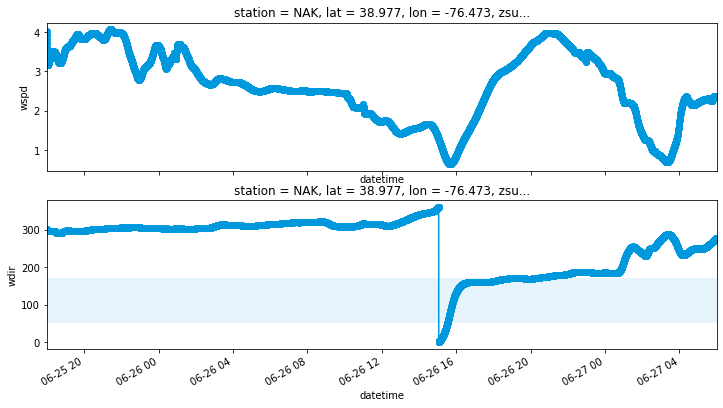

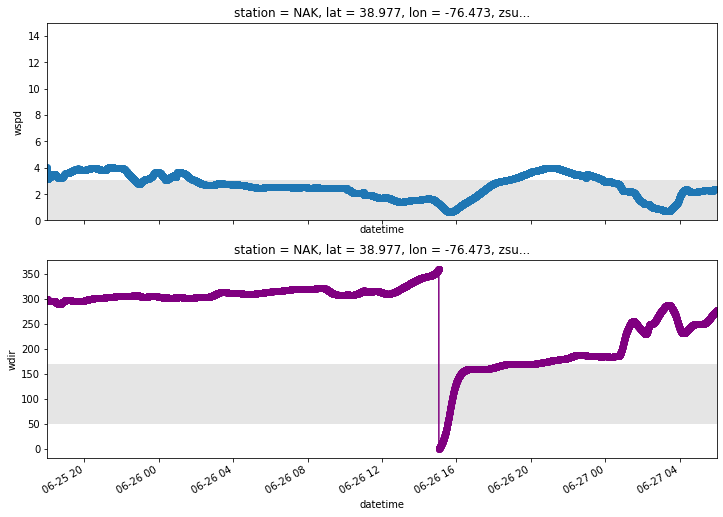

CLR: 12946; OVC: 14
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


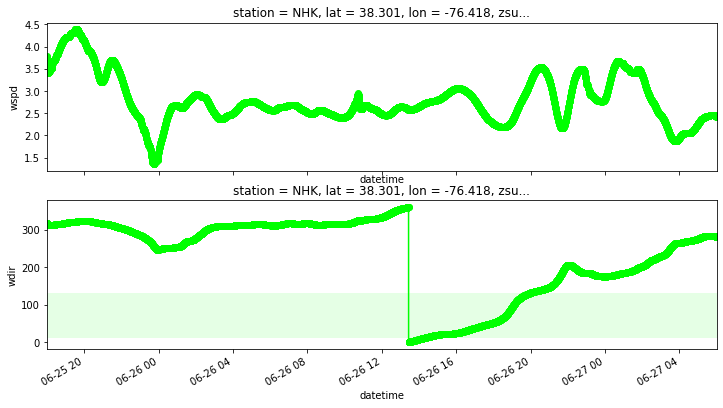

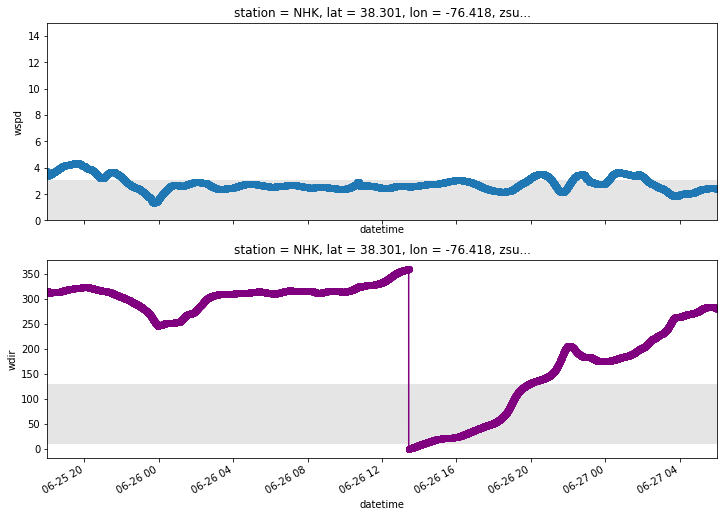

CLR: 11252; OVC: 1708
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


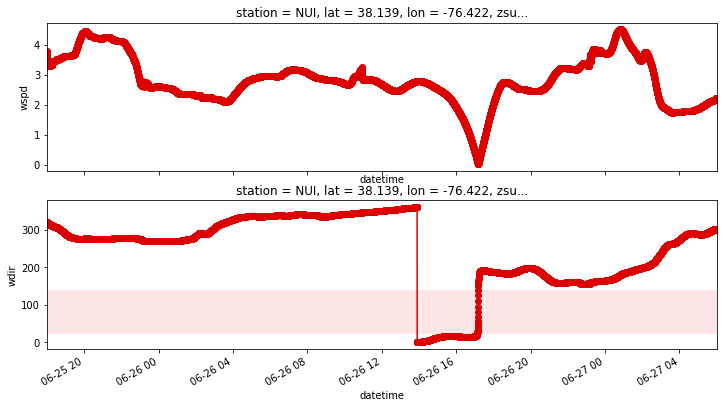

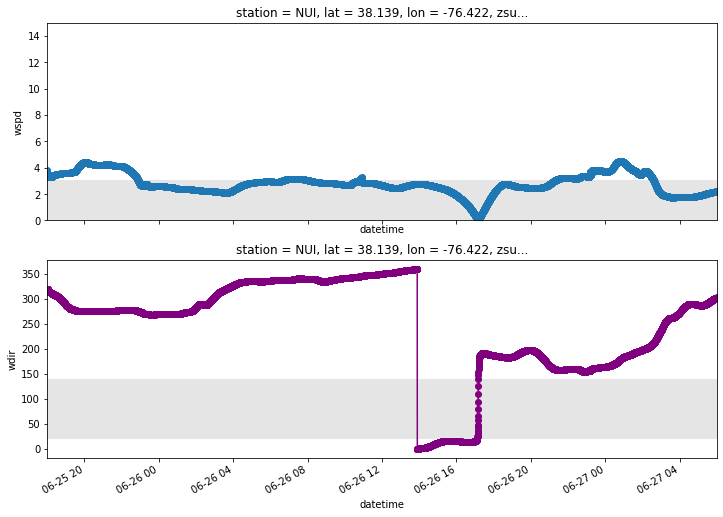

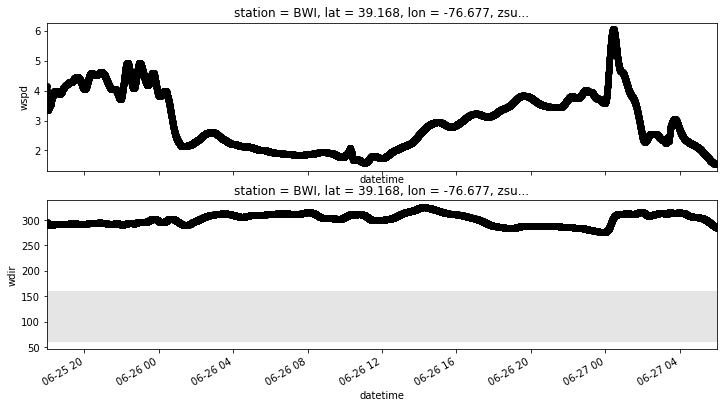

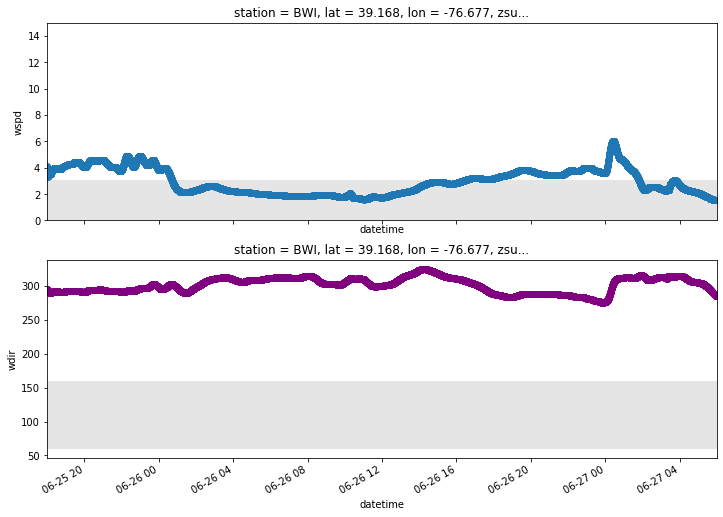

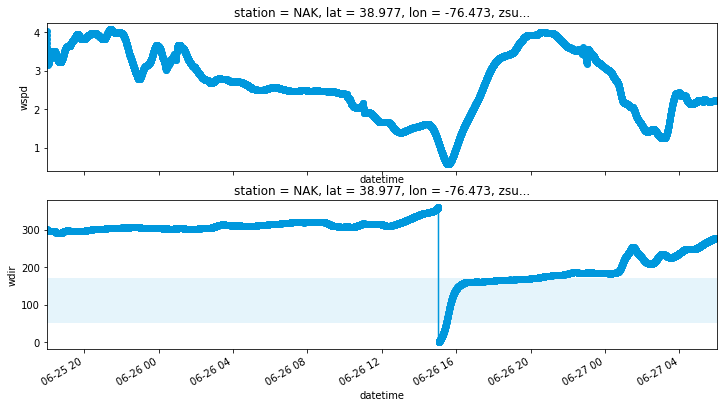

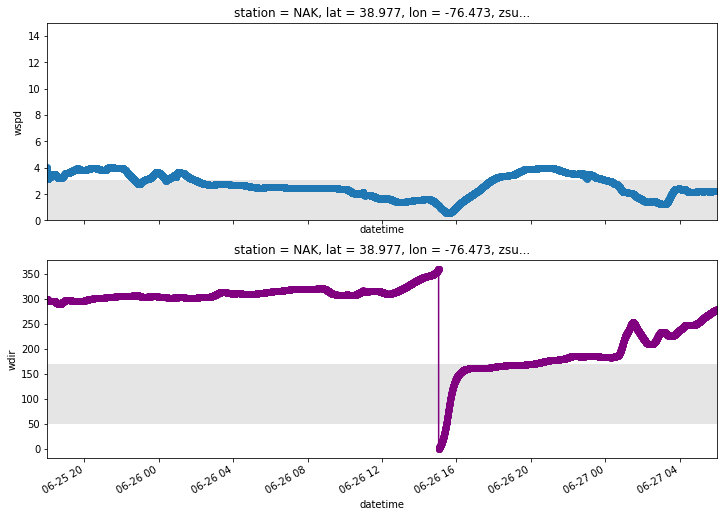

CLR: 12960; OVC: 0
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


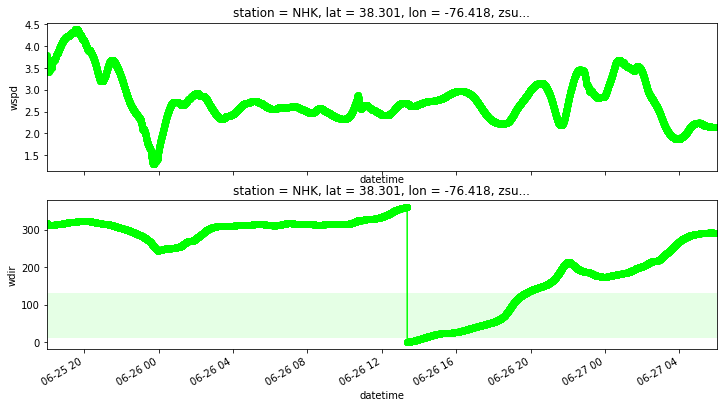

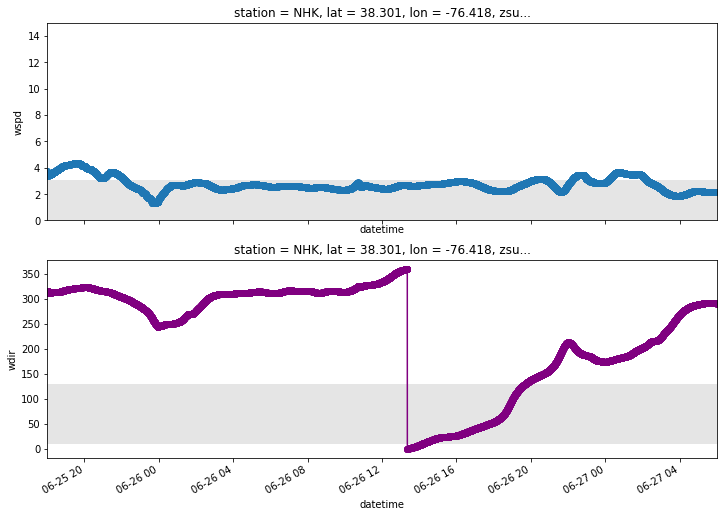

CLR: 11166; OVC: 1794
evaluating clouds
clear skies:  True
dry:  True
BAY BREEZE DETECTED
Bay Breeze Validated!


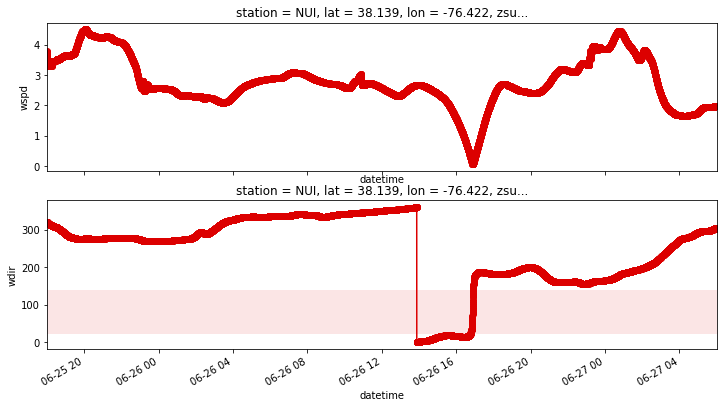

In [618]:
for case in cases:
    wrf_stn = wrf_twrs[case]
    wrf_stn['onshore_min'] = (['station'],[None]*len(wrf_stn.station.data))
    wrf_stn['onshore_max'] = (['station'],[None]*len(wrf_stn.station.data))
    wrf_stn['dwpt'] = T_d(wrf_stn.t2,100.0*(wrf_stn.q2/w_s(wrf_stn.t2, wrf_stn.psfc/100.0)))
    for stn in near_shore_stations: 
        wrf_stn.onshore_min.loc[stn] = case_day_ds.sel(station=stn).onshore_min.data
        wrf_stn.onshore_max.loc[stn] = case_day_ds.sel(station=stn).onshore_max.data
    #for day in pd.date_range(start=start_time, end=end_time):
    inland_station = wrf_stn.sel(station=['IAD','GAI','CJR'])
    for ss,stn in enumerate(near_shore_stations): 
        bay_breeze = bbd.BayBreezeDetection(station,inland_station.isel(nz=1),resample=False,sample_rate='30min',
                                                    show_plot=False,method=detection_method,verbose=False)
        fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True, figsize=(12,6))
        station = wrf_stn.sel(station=stn).sel(datetime=slice(start_time,end_time)).isel(nz=1)

        station.wspd.plot.line(marker='o',ax=ax[0],label=stn,c=coastal_colors[ss])
        station.wdir.plot.line(marker='o',ax=ax[1],c=coastal_colors[ss])
        ax[1].fill_between([pd.to_datetime('2000'),pd.to_datetime('2030')],
                             float(station.onshore_min.values),
                             float(station.onshore_max.values),
                             alpha=0.1,lw=0.0,color=coastal_colors[ss])

        ax[1].set_xlim(station.datetime.data[0],station.datetime.data[-1])

        plt.show()
